# 02: Ames Preprocessing and Linear Regression

Data taken from [Ames, Iowa: Alternative to the Boston Housing Data as an
End of Semester Regression Project](http://jse.amstat.org/v19n3/decock.pdf) by Dean De Cock (hereinafter referred to as 'the author').

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt  
import seaborn as sns 
from scipy import stats

from sklearn.linear_model import LinearRegression, LassoCV, Lasso, RidgeCV, Ridge, ElasticNet, ElasticNetCV
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, PowerTransformer, StandardScaler, OneHotEncoder, FunctionTransformer, QuantileTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

%matplotlib inline

## import and explore initial correlations

In [4]:
train = pd.read_csv('./data/train_eda.csv')
train.shape

(2051, 77)

Per suggestion of the author, it's recommended to removedata points above 4000 square feet (`gr_liv_area`).

In [5]:
train = train[train['gr_liv_area'] <= 4000]
train.shape

(2049, 77)

In [6]:
train.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,...,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,saleprice,age,remod_age
0,MSSC60,RL,0.0,13517,2,3,Lvl,4,CulDSac,3,...,0,0,0,0,mar,ten,WD,130500,34,5
1,MSSC60,RL,43.0,11492,2,3,Lvl,4,CulDSac,3,...,0,0,0,0,apr,nine,WD,220000,13,12
2,MSSC20,RL,68.0,7922,2,4,Lvl,4,Inside,3,...,0,0,0,0,jan,ten,WD,109000,57,3
3,MSSC60,RL,73.0,9802,2,4,Lvl,4,Inside,3,...,0,0,0,0,apr,ten,WD,174000,4,3
4,MSSC50,RL,82.0,14235,2,3,Lvl,4,Inside,3,...,0,0,0,0,mar,ten,WD,138500,110,17


In [7]:
features = train.drop(columns='saleprice')
target = train['saleprice']

## single linear regressions

In [8]:
def adjusted_r2(r2, obs, feats):
    
    # adjust r2 value based on number of observations and number of features
    adjusted = 1 - (1 - r2) * (obs - 1) / (obs - feats - 1)
    
    return adjusted

In [162]:
def regression_stats(model, x, y, random_state=111):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=random_state, test_size=0.5)
    
    model.fit(x_train, y_train)
    y_hat = model.predict(x_test)
    
    adj = adjusted_r2(model.score(x_test, y_test), x_test.shape[0], x_test.shape[1])

    print(f'adjusted r-squared: {adj}')
    print(f'rmse: {mean_squared_error(y_test, y_hat) ** 0.5}')
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        x = y_hat,
        y = y_test - y_hat
    )
    plt.title('residuals vs. predicted', fontsize=12)
    plt.xlabel('predicted values', fontsize=10)
    plt.hlines(y = 0, xmin = y_hat.min(), xmax = y_hat.max(), color = "red")
    plt.show()

    return model

adjusted r-squared: 0.6574848366961862
rmse: 45578.319951505844


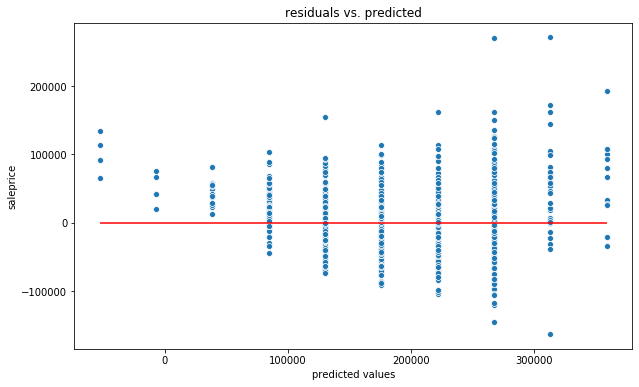

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [163]:
regression_stats(LinearRegression(), features[['overall_qual']], target)

adjusted r-squared: 0.4894869492205024
rmse: 55644.44765910586


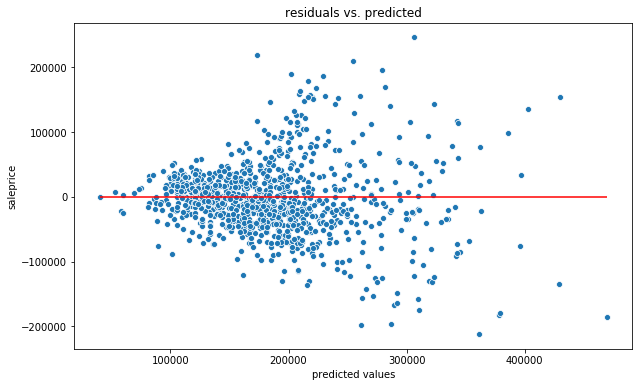

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [164]:
regression_stats(LinearRegression(), features[['gr_liv_area']], target)

Our residuals do not appear to be:
- random
- evenly variant as a function of our predicted value
- insensitive to outliers

Therefore, we should attempt:
- using better (or more) features
- feature engineering
- further preprocessing of our data

## multiple linear regression

adjusted r-squared: 0.7464332771121305
rmse: 39196.94065229168


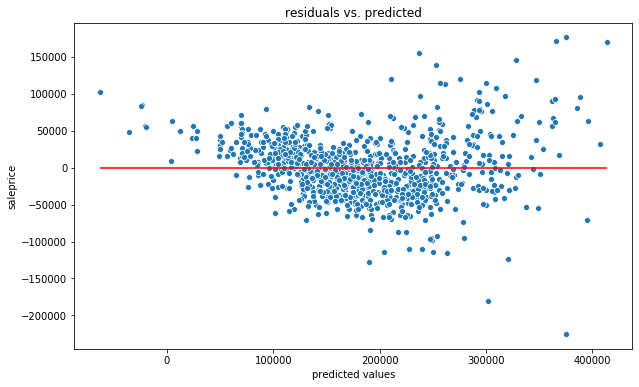

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [165]:
regression_stats(LinearRegression(), features[['gr_liv_area', 'overall_qual']], target)

adjusted r-squared: 0.771262293465705
rmse: 37210.229339795966


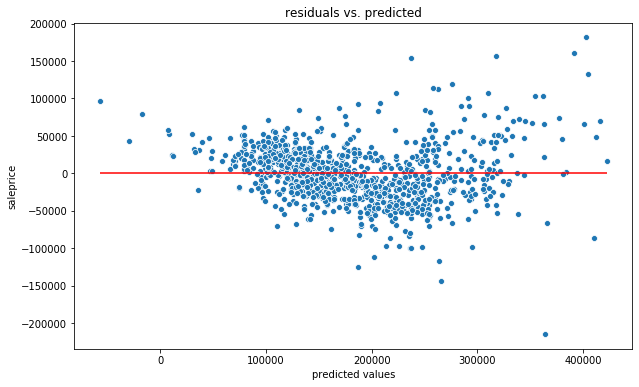

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [166]:
regression_stats(LinearRegression(), features[['gr_liv_area', 'overall_qual', 'exter_qual']], target)

adjusted r-squared: 0.8584357312127511
rmse: 28562.12740472718


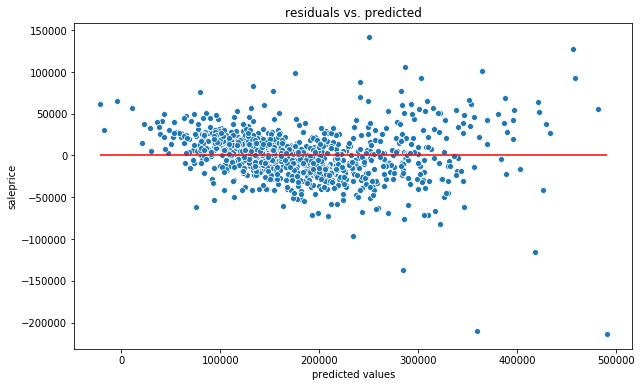

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [167]:
regression_stats(LinearRegression(), features[features.describe().columns], target)

Going at this one-by-one is a time-consuming and probably fruitless task. We will discuss how to 'automate' this process later. The main takeaway is that we can see that adding in more features does improve our scores, 

However, the residuals are still non-homoskedastic (from the "banana" shape). We can attempt to fix this by performing a non-linear transformation of our target `saleprice`.

adjusted r-squared: 0.8550790174358185
rmse: 28898.77022691465


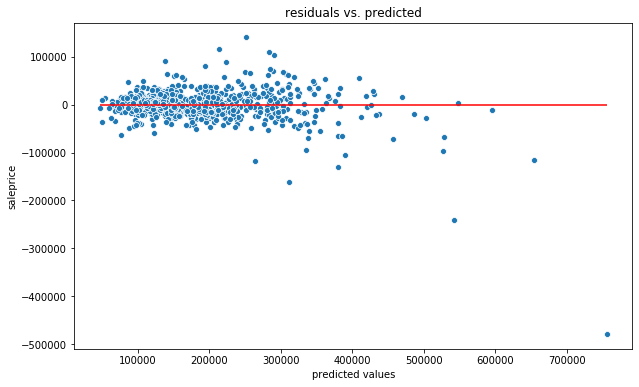

TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
                           regressor=LinearRegression(copy_X=True,
                                                      fit_intercept=True,
                                                      n_jobs=None,
                                                      normalize=False),
                           transformer=PowerTransformer(copy=True,
                                                        method='yeo-johnson',
                                                        standardize=True))

In [168]:
regression_stats(TransformedTargetRegressor(
                    regressor = LinearRegression(),
                    transformer = PowerTransformer()),
                 features[features.describe().columns],
                 target)

We see improvement in the r-squared value, and the residuals have a more even variance.

## using categorical features and more transformations

In [16]:
features.head()

,ms_subclass,ms_zoning,lot_frontage,lot_area,street,lot_shape,land_contour,utilities,lot_config,land_slope,...,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,mo_sold,yr_sold,sale_type,age,remod_age
0,MSSC60,RL,0.0,13517,2,3,Lvl,4,CulDSac,3,...,0,0,0,0,0,mar,ten,WD,34,5
1,MSSC60,RL,43.0,11492,2,3,Lvl,4,CulDSac,3,...,0,0,0,0,0,apr,nine,WD,13,12
2,MSSC20,RL,68.0,7922,2,4,Lvl,4,Inside,3,...,0,0,0,0,0,jan,ten,WD,57,3
3,MSSC60,RL,73.0,9802,2,4,Lvl,4,Inside,3,...,0,0,0,0,0,apr,ten,WD,4,3
4,MSSC50,RL,82.0,14235,2,3,Lvl,4,Inside,3,...,0,0,0,0,0,mar,ten,WD,110,17


In [17]:
features.isna().sum().sum()

0

In [103]:
features.select_dtypes(exclude=['O']).columns.values

array(['lot_frontage', 'lot_area', 'street', 'lot_shape', 'utilities',
       'land_slope', 'overall_qual', 'overall_cond', 'year_built',
       'year_remod_add', 'mas_vnr_area', 'exter_qual', 'exter_cond',
       'bsmt_qual', 'bsmt_cond', 'bsmtfin_sf_1', 'bsmtfin_sf_2',
       'bsmt_unf_sf', 'total_bsmt_sf', 'heating_qc', 'central_air',
       '1st_flr_sf', '2nd_flr_sf', 'low_qual_fin_sf', 'gr_liv_area',
       'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
       'bedroom_abvgr', 'kitchen_abvgr', 'kitchen_qual', 'totrms_abvgrd',
       'functional', 'fireplaces', 'fireplace_qu', 'garage_yr_blt',
       'garage_finish', 'garage_cars', 'garage_area', 'garage_qual',
       'garage_cond', 'paved_drive', 'wood_deck_sf', 'open_porch_sf',
       'enclosed_porch', '3ssn_porch', 'screen_porch', 'pool_area',
       'misc_val', 'age', 'remod_age'], dtype=object)

In [133]:
features.select_dtypes(include=['O']).columns.values

array(['ms_subclass', 'ms_zoning', 'land_contour', 'lot_config',
       'neighborhood', 'condition_1', 'condition_2', 'bldg_type',
       'house_style', 'roof_style', 'roof_matl', 'exterior_1st',
       'exterior_2nd', 'mas_vnr_type', 'foundation', 'bsmt_exposure',
       'bsmtfin_type_1', 'bsmtfin_type_2', 'heating', 'electrical',
       'garage_type', 'mo_sold', 'yr_sold', 'sale_type'], dtype=object)

In [110]:
features.describe()

,lot_frontage,lot_area,street,lot_shape,utilities,land_slope,overall_qual,overall_cond,year_built,year_remod_add,...,paved_drive,wood_deck_sf,open_porch_sf,enclosed_porch,3ssn_porch,screen_porch,pool_area,misc_val,age,remod_age
count,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,...,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000,2049.000000
mean,57.785749,10024.677892,1.996584,3.597365,3.998536,2.947291,6.108346,5.562714,1971.673499,1984.166423,...,1.833577,93.554417,47.224500,22.593948,2.593948,16.527574,2.165935,43.327965,36.102489,23.609566
std,32.633866,6608.511749,0.058363,0.563725,0.049389,0.244378,1.421780,1.104897,30.171293,21.032785,...,0.535028,128.195671,65.857797,59.870165,25.241801,57.399890,36.297124,434.481342,30.204176,21.017265
min,0.000000,1300.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000
25%,43.000000,7500.000000,2.000000,3.000000,4.000000,3.000000,5.000000,5.000000,1953.000000,1964.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000
50%,63.000000,9405.000000,2.000000,4.000000,4.000000,3.000000,6.000000,5.000000,1974.000000,1993.000000,...,2.000000,0.000000,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,15.000000
75%,78.000000,11500.000000,2.000000,4.000000,4.000000,3.000000,7.000000,6.000000,2001.000000,2004.000000,...,2.000000,168.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,54.000000,43.000000
max,313.000000,159000.000000,2.000000,4.000000,4.000000,3.000000,10.000000,9.000000,2010.000000,2010.000000,...,2.000000,1424.000000,547.000000,432.000000,508.000000,490.000000,800.000000,12500.000000,136.000000,60.000000


In [150]:
for col in features.select_dtypes(include=['O']).columns.values:
    print(features[col].value_counts())
    print()

MSSC20     769
MSSC60     393
MSSC50     198
MSSC120    132
MSSC30     101
MSSC70      90
MSSC160     88
MSSC80      86
MSSC90      75
MSSC190     46
MSSC85      28
MSSC75      16
MSSC45      11
MSSC180     11
MSSC40       4
MSSC150      1
Name: ms_subclass, dtype: int64

RL         1596
RM          316
FV          101
C (all)      19
RH           14
A (agr)       2
I (all)       1
Name: ms_zoning, dtype: int64

Lvl    1843
HLS      85
Bnk      78
Low      43
Name: land_contour, dtype: int64

Inside     1502
Corner      347
CulDSac     131
FR2          60
FR3           9
Name: lot_config, dtype: int64

NAmes      310
CollgCr    180
OldTown    163
Edwards    141
Somerst    130
NridgHt    122
Gilbert    116
Sawyer     111
SawyerW     87
NWAmes      87
Mitchel     82
BrkSide     76
Crawfor     71
IDOTRR      69
NoRidge     48
Timber      48
StoneBr     38
SWISU       32
ClearCr     27
MeadowV     24
Blmngtn     22
BrDale      19
Veenker     17
NPkVill     17
Blueste      6
Greens       3


In [173]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

cat_trans = Pipeline([
    ('onehot', OneHotEncoder(categories="auto",
                             handle_unknown='ignore',
                             sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, features.select_dtypes(exclude=['O']).columns.values),
    ('cat', cat_trans, features.select_dtypes(include=['O']).columns.values)
])

tt = TransformedTargetRegressor(
                    regressor = LinearRegression(),
                    func = np.log1p,
                    inverse_func = np.expm1)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', tt)
])

adjusted r-squared: 0.8391057168180142
rmse: 30071.498483753297


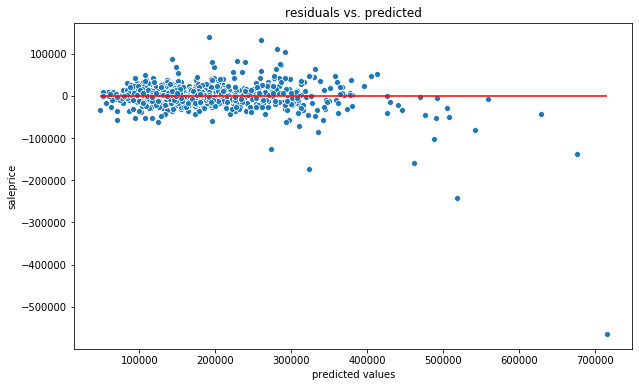

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scale',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                         

In [174]:
regression_stats(pipe, features, target)

adjusted r-squared: 0.8965317356636089
rmse: 24115.05990948539


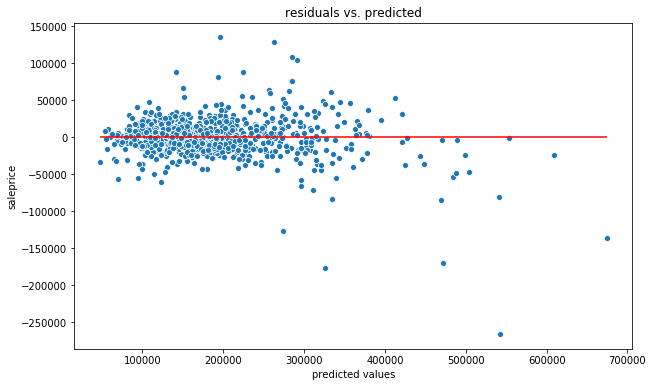

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('scale',
                                                                   RobustScaler(copy=True,
                                                                                quantile_range=(25.0,
                                                                                                75.0),
                                                                                with_centering=True,
                                                                                with_scaling=True))],
                                                         

In [175]:
num_trans = Pipeline([
    ('scale', RobustScaler())
])

cat_trans = Pipeline([
    ('onehot', OneHotEncoder(categories="auto",
                             handle_unknown='ignore',
                             sparse=False))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', num_trans, features.select_dtypes(exclude=['O']).columns.values),
    ('cat', cat_trans, features.select_dtypes(include=['O']).columns.values)
])

tt = TransformedTargetRegressor(
                    regressor = Ridge(),
                    func = np.log1p,
                    inverse_func = np.expm1)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('estimator', tt)
])

regression_stats(pipe, features, target)